# Udacity capstone project
### Data Engineering Capstone Project

#### Project Summary
The aim of this project is to build a data warehouse by extracting data from different sources (immigration, temperature, geolocational,...), creating an ETL pipeline and transforming the data so that it's useable for analytics teams to spot trends, anomalies, etc in the data.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import configparser
import pandas as pd
import configparser
import os
from datetime import datetime
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, expr, split, lower
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SparkSession

### Step 1: Scope the Project and Gather Data

#### Scope 
The aim of this project is to build a data warehouse by extracting data from different sources (immigration, temperature, geolocational,...), creating an ETL pipeline and transforming the data so that it's useable for analytics teams to spot trends, anomalies, etc in the data.
We will extract the data from S3, process, wrangle and create the data model/etl using spark. After these steps we will write the data back to S3
#### Describe and Gather Data 
- I94 Immigration data: This data comes from the US National Tourism and Trade Office and contains data about immigration in the US.
- US cities demographics: This data comes from OpenSoft and contains data about different demographics in US cities such as (population, age, race, etc...)
- Airport codes: Contains data about airport around the globe, such as geolocational data, ISO and IATA codes, etc
- World Temperature data: This is a dataset coming from Kaggle and contains data about temperature and climate change around the globe
- State-codes: Coming from the SAS data dictionary, contains port_codes, state_codes and cities



#### Immigration data

In [2]:
#We'll do the exploratory phase on the sample set, because the full set is rather large
df_immi = pd.read_csv('immigration_data_sample.csv')
df_immi.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


#### Us cities demographics 

In [3]:
# Read in the data here
df_demog = pd.read_csv('us-cities-demographics.csv', sep = ';')
df_demog.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### airport codes

In [4]:
# Read in the data here
df_airport = pd.read_csv('airport-codes_csv.csv')
df_airport.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### Temperature data

In [6]:
# Read in the data here
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temperature = pd.read_csv(fname)
df_temperature.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### state codes

In [7]:
# Read in the data here
df_states = pd.read_csv('state_codes.csv', sep = ";")
df_states.head()

,Port_code,City,State_code,Unnamed: 3
0,ALC,ALCAN,AK,NaN
1,ANC,ANCHORAGE,AK,NaN
2,BAR,BAKER AAF - BAKER ISLAND,AK,NaN
3,DAC,DALTONS CACHE,AK,NaN
4,PIZ,DEW STATION PT LAY DEW,AK,NaN


In [8]:
df_states = df_states[['Port_code', 'City', 'State_code']]

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

#### Demographics (exploring & cleaning)

In [9]:
#check sample
df_demog.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [10]:
#check data types and missing
df_demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


In [11]:
#check for missings
df_demog.isna().sum()

City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
dtype: int64

In [12]:
#Drop zero/NA rows
df_demog.dropna(subset=['Average Household Size'], inplace=True)

In [13]:
# change datatype to Integers
df_demog['Male Population'] = df_demog['Male Population'].astype('int')
df_demog['Female Population'] = df_demog['Female Population'].astype('int')
df_demog['Number of Veterans'] = df_demog['Number of Veterans'].astype('int')
df_demog['Foreign-born'] = df_demog['Foreign-born'].astype('int')

In [14]:
#check data types and missing
df_demog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875 entries, 0 to 2890
Data columns (total 12 columns):
City                      2875 non-null object
State                     2875 non-null object
Median Age                2875 non-null float64
Male Population           2875 non-null int64
Female Population         2875 non-null int64
Total Population          2875 non-null int64
Number of Veterans        2875 non-null int64
Foreign-born              2875 non-null int64
Average Household Size    2875 non-null float64
State Code                2875 non-null object
Race                      2875 non-null object
Count                     2875 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 292.0+ KB


In [15]:
#check dimensions
df_demog.shape

(2875, 12)

In [16]:
#check if duplicated rows
df_demog.duplicated().sum()

0

In [17]:
#check statistics of numerical columns
df_demog.describe()

,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,Count
count,2875.000000,2.875000e+03,2.875000e+03,2.875000e+03,2875.000000,2.875000e+03,2875.000000,2.875000e+03
mean,35.434678,9.744502e+04,1.018469e+05,1.992919e+05,9361.714435,4.069181e+04,2.742543,4.886379e+04
std,4.250501,2.167572e+05,2.320513e+05,4.487144e+05,13216.754474,1.558259e+05,0.433291,1.446315e+05
min,22.900000,2.928100e+04,2.734800e+04,6.321500e+04,416.000000,8.610000e+02,2.000000,9.800000e+01
25%,32.800000,3.931400e+04,4.122700e+04,8.043800e+04,3737.500000,9.224000e+03,2.430000,3.454000e+03
50%,35.300000,5.233600e+04,5.380900e+04,1.067820e+05,5397.000000,1.883000e+04,2.650000,1.378000e+04
75%,38.000000,8.668750e+04,8.958900e+04,1.753080e+05,9368.000000,3.400300e+04,2.950000,5.414650e+04
max,48.800000,4.081698e+06,4.468707e+06,8.550405e+06,156961.000000,3.212500e+06,4.980000,3.835726e+06


#### Temperature (exploring & cleaning)





In [18]:
#check sample
df_temperature.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [19]:
#check data types and missing
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [20]:
#check dimensions
df_temperature.shape

(8599212, 7)

In [21]:
#check statistics of numerical columns
df_temperature.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [22]:
#check if duplicated rows
df_temperature.duplicated().sum()

0

In [23]:
#check count per country
df_temperature['Country'].value_counts()

India                       1014906
China                        827802
United States                687289
Brazil                       475580
Russia                       461234
Japan                        358669
Indonesia                    323255
Germany                      262359
United Kingdom               220252
Mexico                       209560
Nigeria                      172347
Spain                        159594
Iran                         151651
Turkey                       150306
Pakistan                     139231
Italy                        136038
Philippines                  127700
Poland                       123082
France                       116604
South Africa                  94050
Venezuela                     91080
Colombia                      88017
Romania                       80975
Ukraine                       77736
Netherlands                   77736
Canada                        75445
Malaysia                      72480
Vietnam                     

In [24]:
#since we will be only focussing on US data (since immigration and demographics data is only available for US), 
#all other rows will be deleted out of the dataset
df_temperature = df_temperature[df_temperature['Country'] == 'United States']

In [25]:
#check for NaN values in entire dataset
df_temperature.isna().sum()

dt                                   0
AverageTemperature               25765
AverageTemperatureUncertainty    25765
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [26]:
#change datatype to datetime
df_temperature['dt'] = pd.to_datetime(df_temperature['dt'])

In [27]:
#Drop zero/NA rows
df_temperature.dropna(subset=['AverageTemperature'], inplace=True)

#### Airport Codes (exploring & cleaning)


In [28]:
#check sample
df_airport.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [29]:
#check dimensions
df_airport.shape

(55075, 12)

In [30]:
#check data types and missing
df_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [31]:
#check if duplicated rows
df_airport.duplicated().sum()

0

In [32]:
#Count values per country
df_airport['iso_country'].value_counts()

US    22757
BR     4334
CA     2784
AU     1963
KR     1376
MX     1181
RU     1040
DE      947
GB      911
FR      850
AR      848
CO      706
IT      671
PG      593
VE      592
ZA      489
CL      474
ID      470
ES      416
CN      404
KE      372
IN      341
CD      285
PH      282
PL      278
CZ      269
JP      234
NO      228
SE      224
NZ      212
      ...  
MF        2
KN        2
SM        2
PM        2
SH        2
MS        2
BN        2
LC        2
WF        2
DM        2
MC        2
YT        1
MO        1
LI        1
NU        1
BL        1
CX        1
JE        1
AW        1
SX        1
CC        1
CW        1
IO        1
AI        1
MQ        1
VA        1
NR        1
GM        1
NF        1
GI        1
Name: iso_country, Length: 243, dtype: int64

In [33]:
#since we will be only focussing on US data (since immigration and demographics data is only available for US), 
#all other rows will be deleted out of the dataset
df_airport = df_airport[df_airport['iso_country'] == 'US']

In [34]:
#check missings
df_airport.isna().sum()

ident               0
type                0
name                0
elevation_ft      239
continent       22756
iso_country         0
iso_region          0
municipality      102
gps_code         1773
iata_code       20738
local_code       1521
coordinates         0
dtype: int64

In [35]:
#check duplicated in identity code
df_airport.ident.duplicated().sum()

0

In [36]:
#split iso-region into country and state
df_airport[['country', 'state_code']] = df_airport['iso_region'].str.split('-', n=1, expand=True)

In [37]:
#drop country and iso_region columns
df_airport = df_airport.drop(['iso_region', 'country'], axis = 1)

In [38]:
df_airport.head()

,ident,type,name,elevation_ft,continent,iso_country,municipality,gps_code,iata_code,local_code,coordinates,state_code
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125",PA
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022",KS
2,00AK,small_airport,Lowell Field,450.0,NaN,US,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968",AK
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172",AL
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,Newport,NaN,NaN,NaN,"-91.254898, 35.6087",AR


#### Immigration (exploring & cleaning)


In [39]:
#Check sample
df_immi.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [40]:
df_immi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
Unnamed: 0    1000 non-null int64
cicid         1000 non-null float64
i94yr         1000 non-null float64
i94mon        1000 non-null float64
i94cit        1000 non-null float64
i94res        1000 non-null float64
i94port       1000 non-null object
arrdate       1000 non-null float64
i94mode       1000 non-null float64
i94addr       941 non-null object
depdate       951 non-null float64
i94bir        1000 non-null float64
i94visa       1000 non-null float64
count         1000 non-null float64
dtadfile      1000 non-null int64
visapost      382 non-null object
occup         4 non-null object
entdepa       1000 non-null object
entdepd       954 non-null object
entdepu       0 non-null float64
matflag       954 non-null object
biryear       1000 non-null float64
dtaddto       1000 non-null object
gender        859 non-null object
insnum        35 non-null float64
airline       967 non

In [41]:
#keep only columns: CIC Id, Arrival date, departure date, Country of resident, City of resident, Port code, Model, gender, Birthyear, visa
df_immi = df_immi[['cicid', 'i94cit', 'i94port', 'arrdate', 'i94mode', 'depdate', 'i94visa', 'gender', 'biryear', 'i94bir']]

In [42]:
#check duplicated
df_immi.duplicated().sum()

0

In [43]:
#check duplicated cicid
df_immi['cicid'].duplicated().sum()

0

In [44]:
#change datetypes
df_immi['biryear'] = df_immi['biryear'].astype('int')
df_immi['i94bir'] = df_immi['i94bir'].astype('int')
df_immi['i94mode'] = df_immi['i94mode'].astype('int')
df_immi['cicid'] = df_immi['cicid'].astype('int')
df_immi['i94visa'] = df_immi['i94visa'].astype('int')
df_immi['i94cit'] = df_immi['i94cit'].astype('int')
df_immi['arrdate'] = pd.to_datetime(df_immi['arrdate'])
df_immi['depdate'] = pd.to_datetime(df_immi['depdate'])

In [45]:
df_immi.head()

,cicid,i94cit,i94port,arrdate,i94mode,depdate,i94visa,gender,biryear,i94bir
0,4084316,209,HHW,1970-01-01 00:00:00.000020566,1,1970-01-01 00:00:00.000020573,2,F,1955,61
1,4422636,582,MCA,1970-01-01 00:00:00.000020567,1,1970-01-01 00:00:00.000020568,2,M,1990,26
2,1195600,148,OGG,1970-01-01 00:00:00.000020551,1,1970-01-01 00:00:00.000020571,2,M,1940,76
3,5291768,297,LOS,1970-01-01 00:00:00.000020572,1,1970-01-01 00:00:00.000020581,2,M,1991,25
4,985523,111,CHM,1970-01-01 00:00:00.000020550,3,1970-01-01 00:00:00.000020553,2,F,1997,19


In [46]:
df_states.head()

,Port_code,City,State_code
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK


In [47]:
#add state code and city from state_codes.csv
df_immi = pd.merge(df_immi, df_states[['Port_code','City', 'State_code']], left_on = 'i94port', right_on = 'Port_code', how='left').head(20)

In [48]:
#drop port_code since it is the same value as i94port
df_immi = df_immi.drop('Port_code', axis = 1)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

The conceptual model consists out of following tables and is made according a star scheme model since this is easy to build and clear for users.:
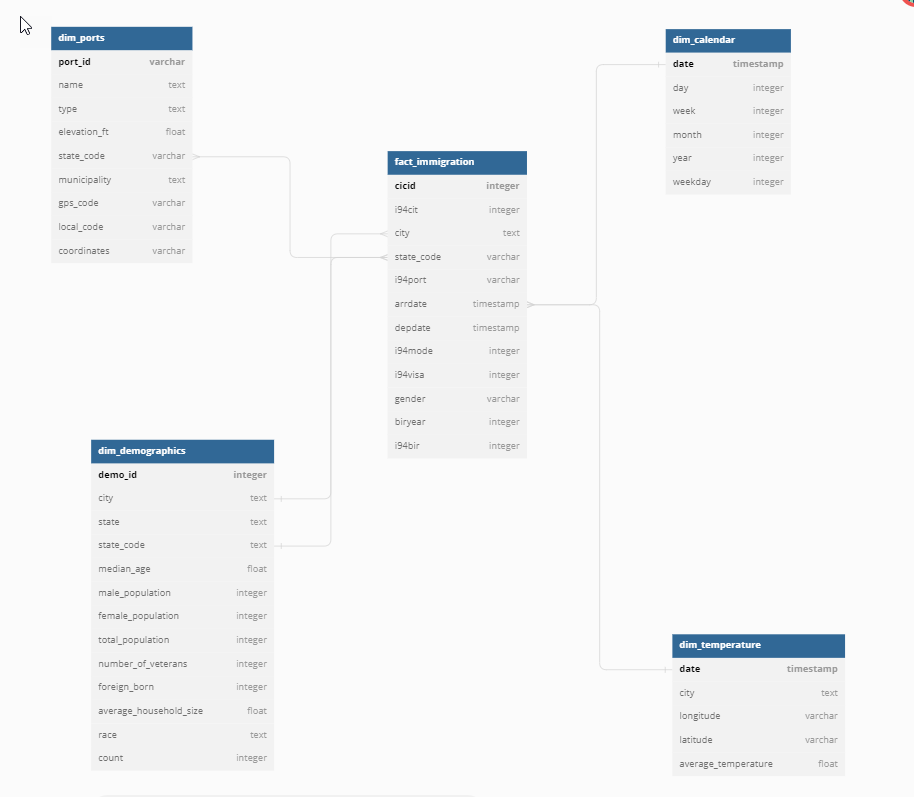

The immigration table is the fact table in the data model.
<br> Calendar, temperature, demographics and airports are the dimension tables. You can find the primary keys and relationship between the fact and dimension tables in model above.
#### 3.2 Mapping Out Data Pipelines 

1. First step is to launch a spark session
2. In next step we will load the datasets from S3
3. Create the dimension tables (demographics, temperature, calendar & airport)s
4. wrangle the dimension tables
5. write the dimension tables back to S3
6. Create the fact table (immigration)
7. Wrrangle the fact table
8. Write it back to S3

In the notebook I've made the decision to store the files locally. But in the workspace you can also find the etl script with connections to S3

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [5]:
#create spark session
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
config("spark.driver.memory", "4g"). \
config("spark.executor.memory", "4g"). \
enableHiveSupport().getOrCreate()


In [47]:
#read airport csv file
air_df = spark.read.format("csv").option("header", "true").load("airport-codes_csv.csv")

#keep only US states
air_df = air_df.where("iso_country = 'US'")
    
#extract columns to create airport tabel
airport_table = air_df.selectExpr("ident", "type", "name", "elevation_ft", "iso_region", "municipality", "gps_code", "local_code", "coordinates").orderBy("ident")

#drop duplicates
airport_table = airport_table.dropDuplicates(["ident"])
    
#rename columns
airport_table = airport_table.withColumnRenamed("ident", "port_id")

#Split iso_region column to into country and state column
airport_table = airport_table.withColumn("state_code", split(col("iso_region"), "-").getItem(1))

#drop country column since all logs in the table are USA based
airport_table = airport_table.drop(col("country"))
    
# write airports table to parquet file)
airport_table.createOrReplaceTempView("airports")
airport_table.write.mode('overwrite').parquet("airports")

In [7]:
# read demographics csv file
demo_df = spark.read.format("csv").option("delimiter", ";").option("header", "true").load("us-cities-demographics.csv")

# Extract columns to create demographics table
demo_table = demo_df.selectExpr(
    "City as city",
    "State as state",
    "`State Code` as state_code",
    "`Median Age` as median_age",
    "`Male Population` as male_population",
    "`Female Population` as female_population",
    "`Total Population` as total_population",
    "`Number of Veterans` as number_of_veterans",
    "`Foreign-born` as foreign_born",
    "`Average Household Size` as average_household_size",
    "Race as race",
    "Count as count"
)

# Create unique ID
demo_table = demo_table.withColumn("demo_id", F.monotonically_increasing_id())

# Data wrangling
demo_table = demo_table.na.drop(subset=["average_household_size"])
demo_table = demo_table \
    .withColumn("male_population", col("male_population").cast("int")) \
    .withColumn("female_population", col("female_population").cast("int")) \
    .withColumn("number_of_veterans", col("number_of_veterans").cast("int")) \
    .withColumn("foreign_born", col("foreign_born").cast("int")) \
    .withColumn("city", lower(col("city")))
# Write demographic table to parquet file
demo_table.createOrReplaceTempView("demographics")
demo_table.write.mode('overwrite').parquet("demographics")

In [8]:
# read temperature csv file
temp_df = spark.read.format("csv").option("header", "true").load("../../data2/GlobalLandTemperaturesByCity.csv")
    
# Get only rows from related to USA
temp_df = temp_df.where("Country = 'United States'")
    
# Extract columns to create temperature table
temp_table = temp_df.selectExpr("dt", "City as city", "Longitude as longitude", "Latitude as latitude", "AverageTemperature as average_temperature").orderBy("dt")
    
# Wrangling
temp_table = temp_table.withColumn("dt", col("dt").cast("date"))
temp_table = temp_table.na.drop(subset=["average_temperature"])
    
# write temperature table to parquet file
temp_table.createOrReplaceTempView("temperature")
temp_table.write.mode('overwrite').parquet("temperature")

In [9]:
# Read the SAS files using the sas7bdat package
immig_df = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [10]:
#Extract columns to make immigration table
immig_table = immig_df.selectExpr("cicid", "i94cit", "i94port", "arrdate", "i94mode", "depdate", "i94visa", "gender", "biryear", "i94bir").orderBy("cicid")

In [11]:
# Read states_code csv into table
states_df = spark.read.format("csv").option("delimiter", ";").option("header", "true").load("state_codes.csv")

#Extract columns
states_table = states_df.selectExpr("Port_code as port_code", "City as city", "State_code as state_code")

In [12]:
#Wrangling
immig_table = immig_table.dropDuplicates(["cicid"])
immig_table = immig_table.withColumn("biryear", col("biryear").cast("int"))
immig_table = immig_table.withColumn("i94bir", col("i94bir").cast("int"))
immig_table = immig_table.withColumn("i94mode", col("i94mode").cast("int"))
immig_table = immig_table.withColumn("cicid", col("cicid").cast("int"))
immig_table = immig_table.withColumn("i94cit", col("i94cit").cast("int"))
immig_table = immig_table.withColumn("i94visa", col("i94visa").cast("int"))
immig_table = immig_table.withColumn("arrdate", expr("date_add(to_date('1960-01-01'), arrdate)"))
immig_table = immig_table.withColumn("depdate", expr("date_add(to_date('1960-01-01'), depdate)"))

In [13]:
#add city and state_code columns into immig_table
immig_table = immig_table.join(states_table, immig_table.i94port == states_table.port_code, "left")

In [14]:
#lowercase column city
immig_table = immig_table.withColumn("city", lower(col("city")))

In [15]:
# Write immigration table to parquet file
immig_table.createOrReplaceTempView("immigration")
immig_table.write.mode("overwrite").parquet("immigration")

In [16]:
# Extract columns to make calender table
calendar_table = immig_table.withColumn("arrdate_int", F.dayofyear("arrdate"))
calendar_table = calendar_table.withColumn("arrdate", expr("date_add(to_date('1960-01-01'), arrdate_int)"))
calendar_table = calendar_table.select(
    F.col("arrdate").alias("date"),
    F.dayofyear("arrdate").alias("day"),
    F.weekofyear("arrdate").alias("week"),
    F.month("arrdate").alias("month"),
    F.year("arrdate").alias("year"),
    F.dayofweek("arrdate").alias("weekday")
).dropDuplicates(["date"])

In [17]:
# Write calendar table to parquet file
calendar_table.createOrReplaceTempView("calendar")
calendar_table.write.mode('overwrite').parquet("calendar")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
As a quality check I've wrote a definition to check if the fact and dimension tables are populated correctly and gives a warning if it did not happen
 
Run Quality Checks

In [48]:
# Quality check on airport table
airports_table = spark.read.parquet("airports")
if airports_table.count() == 0:
    raise ValueError("Airports table is empty, please try agbain or double check etl Code")

In [49]:
# show datatypes
for field in airports_table.schema.fields:
    print(field.name +" , "+str(field.dataType))

port_id , StringType
type , StringType
name , StringType
elevation_ft , StringType
iso_region , StringType
municipality , StringType
gps_code , StringType
local_code , StringType
coordinates , StringType
state_code , StringType


In [41]:
# Quality check on demographics table
demographics_table = spark.read.parquet("demographics")
if demographics_table.count() == 0:
    raise ValueError("Demographics table is empty, please try again or double check etl Code")

In [24]:
# show datatypes
for field in demographics_table.schema.fields:
    print(field.name +" , "+str(field.dataType))

city , StringType
state , StringType
state_code , StringType
median_age , StringType
male_population , IntegerType
female_population , IntegerType
total_population , StringType
number_of_veterans , IntegerType
foreign_born , IntegerType
average_household_size , StringType
race , StringType
count , StringType
demo_id , LongType


In [27]:
# quality check on temperature table
temperature_table = spark.read.parquet("temperature")
if temperature_table.count() == 0:
    raise ValueError("Temperature table is empty, please try again or double check etl Code")

In [28]:
# show datatypes
for field in temperature_table.schema.fields:
    print(field.name +" , "+str(field.dataType))

dt , DateType
city , StringType
longitude , StringType
latitude , StringType
average_temperature , StringType


In [29]:
# Quality check on immigration table
immigration_table = spark.read.parquet("immigration")
if immigration_table.count() == 0:
    raise ValueError("Immigration table is empty, please try again or double check etl Code")

In [30]:
# show datatypes
for field in immigration_table.schema.fields:
    print(field.name +" , "+str(field.dataType))

cicid , IntegerType
i94cit , IntegerType
i94port , StringType
arrdate , DateType
i94mode , IntegerType
depdate , DateType
i94visa , IntegerType
gender , StringType
biryear , IntegerType
i94bir , IntegerType
port_code , StringType
city , StringType
state_code , StringType


In [32]:
# Quality check on calendar table
calendar_table = spark.read.parquet("calendar")
if calendar_table.count() == 0:
    raise ValueError("Calendar table is empty, please try again or double check etl Code")  

In [33]:
# show datatypes
for field in calendar_table.schema.fields:
    print(field.name +" , "+str(field.dataType))

date , DateType
day , IntegerType
week , IntegerType
month , IntegerType
year , IntegerType
weekday , IntegerType


#### Examples of how to use this code

we can use pyspark.sql to query the data easily and investigate/analyse the data

In [53]:
#check distinct count calendar
calendar_table.createOrReplaceTempView("calendar")

In [52]:
spark.sql("""
SELECT COUNT (DISTINCT date)
FROM calendar
""").show()

+--------------------+
|count(DISTINCT date)|
+--------------------+
|                  30|
+--------------------+



In [79]:
calendar_table.count()

30

In [54]:
# upload immigration table
immigration_table.createOrReplaceTempView("immigration")

In [67]:
#check average age grouped by gender
spark.sql("""
SELECT AVG(i94bir) as average_age, gender
FROM immigration
GROUP BY gender
""").show()

+------------------+------+
|       average_age|gender|
+------------------+------+
|41.679165460577586|     F|
| 42.38668446512885|  null|
| 41.66548024613445|     M|
|44.333333333333336|     U|
| 40.99068322981366|     X|
+------------------+------+



In [71]:
#check count per state
spark.sql("""
SELECT state_code, COUNT(cicid) as amount
FROM immigration
GROUP BY state_code
ORDER BY amount DESC
""").show()

+----------------+------+
|      state_code|amount|
+----------------+------+
|    NY          |488417|
| FL             |369573|
|       CA       |310163|
|   FL           |159354|
|         CA     |152586|
|    HI          |142720|
|            NJ  |136122|
|   IL           |130564|
|           FL   |106153|
|   TX           |102605|
|            null|100723|
|   GA           | 92579|
|     NV         | 89280|
| GU             | 80919|
|  TX            | 75542|
|  MA            | 57354|
|   WA           | 47731|
|   AZ           | 39287|
|   MI           | 37843|
|              CA| 29848|
+----------------+------+
only showing top 20 rows



In [72]:
# show sample of immigration table
spark.sql("""
SELECT *
FROM immigration
""").show()

+------+------+-------+----------+-------+----------+-------+------+-------+------+---------+-------+--------------+
| cicid|i94cit|i94port|   arrdate|i94mode|   depdate|i94visa|gender|biryear|i94bir|port_code|   city|    state_code|
+------+------+-------+----------+-------+----------+-------+------+-------+------+---------+-------+--------------+
|370291|   582|    ORL|2016-04-02|      1|2016-04-07|      2|     F|   1984|    32|      ORL|orlando| FL           |
|370292|   582|    ORL|2016-04-02|      1|2016-04-07|      2|     M|   1984|    32|      ORL|orlando| FL           |
|370293|   582|    ORL|2016-04-02|      1|2016-04-07|      2|     M|   1987|    29|      ORL|orlando| FL           |
|370294|   582|    ORL|2016-04-02|      1|2016-04-07|      2|     F|   1995|    21|      ORL|orlando| FL           |
|370295|   582|    ORL|2016-04-02|      1|2016-04-07|      2|     F|   1997|    19|      ORL|orlando| FL           |
|370296|   582|    ORL|2016-04-02|      1|2016-04-07|      2|   

#### 4.3 Data dictionary 

Immigration table (Fact table)


| Code     | Description                                     |
| -------- | ----------------------------------------------- |
| CICID | Unique ID                                       |
| I94CIT   | Birth country of immigrant (3 digit code)       |
| City   | City of admission immigrant       |
| State_code   | State of admission immigrant (Code)       |
| I94PORT  | Port of admission immigrant                     |
| ARRDATE  | The arrival date in the USA                      |
| I94MODE  | Mode of transportation                          |
| DEPDATE  | The departure date from the USA                  |
| I94VISA  | Visa codes collapsed into three categories  (1 = business, 2 = pleasure, 3 = student     |
| GENDER   | Non-immigrant sex                               |
| BIRYEAR  | 4-digit year of birth                           |
| I94BIR   | Age of respondent in years                      |
| I94ADDR   | State Code                     |

<br> Calendar table (dimension) <br>

| Code  | Description      |
|-------|------------------|
| Date  | Arrival date     |
| Day   | Day of arrival   |
| Week  | Week of arrival  |
| Month | Month of arrival |
| Year  | Year of arrival  |
| Weekday | Day of week  |

<br> Demographics table (dimension) <br>

| Code  | Description      |
|-------|------------------|
| City  | City Name     |
| State   | State Name   |
| state_code  | State Code  |
| median_age| Median age of population|
| male_population  | Count of male population  |
| female_population | Count of female population  |
| total_population | Count of total population  |
| foreign_born | count of foreign born population  |
| average_household_size | Average size of household in the population |
| Race| Race of population  |
| Count | Count of population  |
| number_of_veterans | Count of veterans in population  |

<br> Temperature table (dimension) <br>

| Code  | Description      |
|-------|------------------|
| dt  | Date     |
| city   | City Name   |
| average_temperature  | Average temperature in city on specific date  |
| longitude | Longitude of city|
| latitude  | Latitude of city  |

<br> airport table (dimension) <br>

| Code  | Description      |
|-------|------------------|
| port_id  | unique port code    |
| type   | airport type   |
| name  | name of airport |
| elevation_ft | elevation of airport|
| state_code | state in US (code)  |
| municipality | town/district of airport  |
| gps_code | gps code of airport |
| local_code | local code of airport  |
| coordinates | locational coordinates of airport  |


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

For this case I've used spark because this tool/technology is capable of handling very large datasets. Next to that it is easy to use and it gives u you the possibility to use SQl and pyspark.SQL. Sparks is also easily scalable by inscreasing the nodes/serves in the S3 clusters

* Propose how often the data should be updated and why.

Since the datasource that we used as our facttable is only updated once a month, it's perfectly fine to update our database once a month as well

* Write a description of how you would approach the problem differently under the following scenarios:

 * The data was increased by 100x.
 
 Like mentioned above if data is increased by 100x we can increase the number of nodes in the cluster to handle the increase.
 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
 Airflow is good tool to handle a data pipeline that runs on a daily basis.
 
 * The database needed to be accessed by 100+ people.
 
 In this case we can use Redshift AWS if a lot of users needs access to this data.